# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# ----------------------------------------------------------------------
# OV BROAD SEGMENT only loss RUNS
# ----------------------------------------------------------------------

# Set parameters

In [1]:
mutationmatrix = '/Users/jlu96/maf/new/OV_broad/OV_broad-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/OV_broad/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/OV_broad-seg-jl-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 10
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 30
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

5180 genes x 140 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


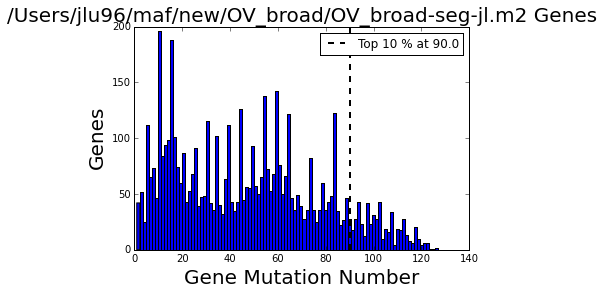

Zoomed into bottom 95 percent region


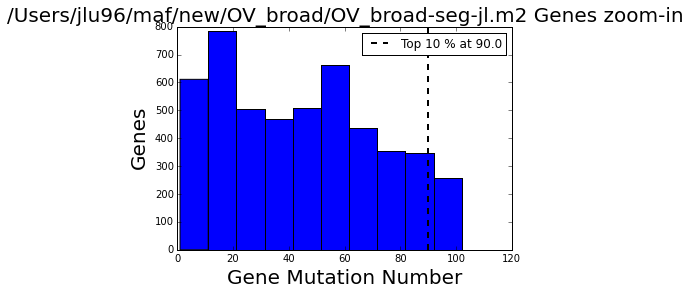


PATIENT MUTATION DISTRIBUTION


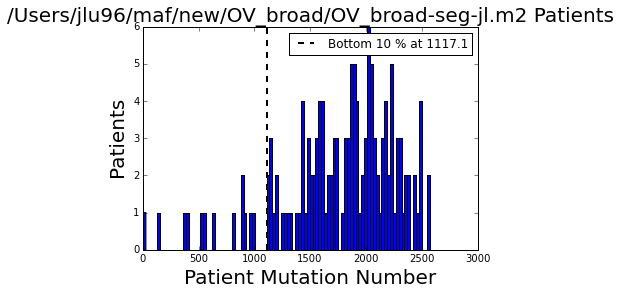

Zoomed into bottom 95 percent region


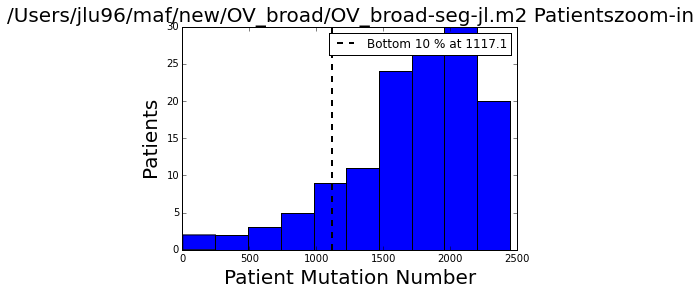

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


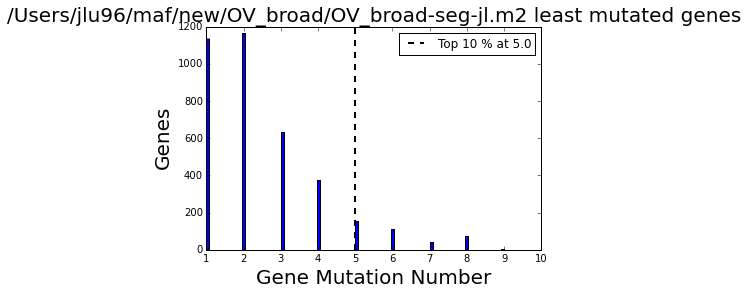


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


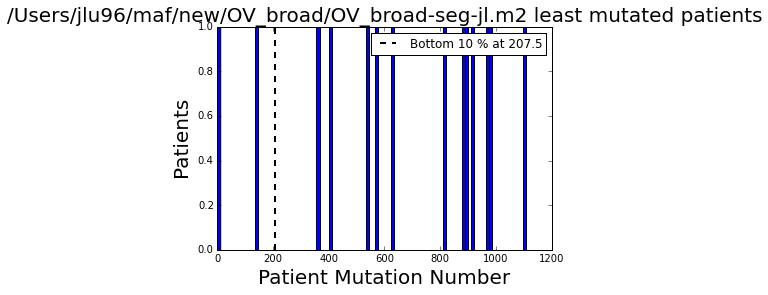

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  10  % of patients
Least mutated patients: 3694 genes x 14 patients
The test gene threshold is  30 % of the least mutated patients
Test genes are mutated at least  4  in th least mutated patients
Number of test genes:  762
Number of pairs to test:  263921
Number of pairs is  263921  retrieved in time :  14.628483057


0

In [2]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  213.818610191
Testing among least mutated patients...
Finished in  508.455064058
All pairs tested in least mutated patients written to  output/OV_broad-seg-jl-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


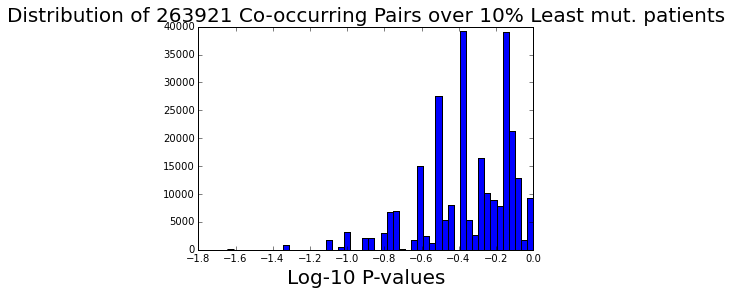

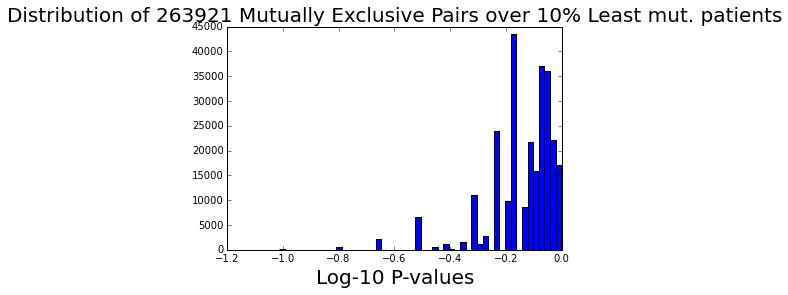

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [5]:
cpairPercentile = 1
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 0.001

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  1 percent of cooccurring pairs:  0.0882002645013
Top  0.001 percent of mutually exclusive pairs :  0.0977075747497
Now number of mutex pairs to test  7
Now number of coocurr pairs to test  2665
Number of genes  316


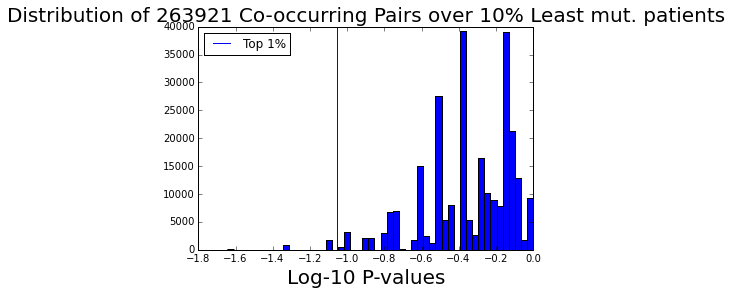

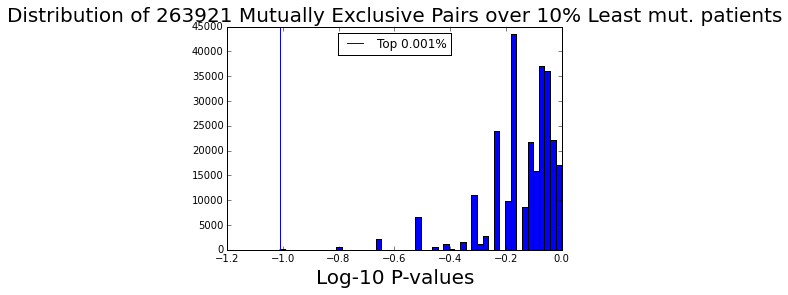

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [7]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/OV_broad-seg-jl--pairs-min_cohort_filtered.txt


0

### Plot results

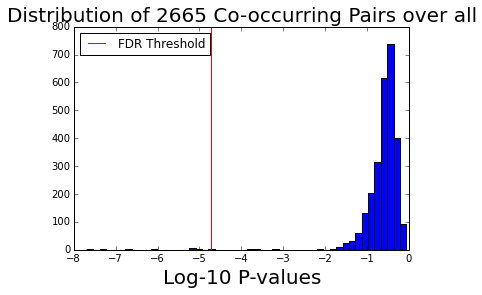

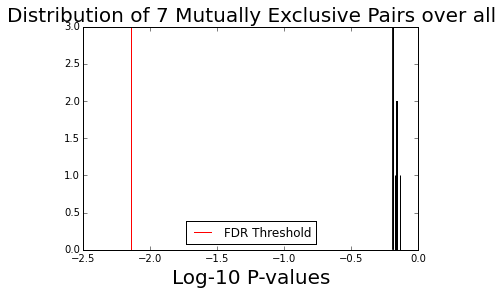

Number significant mutex 0
Number significant coocurr 22


In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [11]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/OV_broad-seg-jl--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-seg-jl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

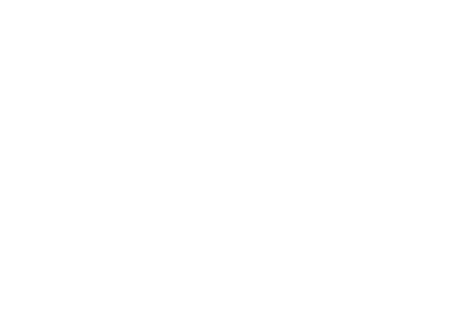

In [12]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [13]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

22  Co-occurring pairs
updated with segment info  output/OV_broad-seg-jl--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-seg-jl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 15
RN7SL605Ploss has 7
CECR2loss has 1
MIR648loss has 1
CABIN1loss has 1
SPECC1L_ADORA2Aloss has	1
SUSD2_GGT5_POM1loss has	1
PPM1F_TOP3B_VPRloss has	1
OR1D5_OR1D2_OR1loss has	1
RN7SL624Ploss has 1
SGSM1_TMEM211_Kloss has	1
SLC25A18_ATP6V1loss has	1
PIWIL3loss has 1
RN7SL33P_PAFAH1loss has	1
OR11H1_POTEH_KCloss has	1
MICAL3loss has 1
MAPK1loss has 1
RNA5SP493loss has 1
SMG6loss has 1
RAP1GAP2loss has 1
SRR_TSR1_SNORD9loss has	1
RTN4RL1_DPH1_OVloss has	1
PEX26_TUBA8_USPloss has	1
IGLL1_GUSBP11_Rloss has	1

**********SINGLE CYTOBANDS**********
['13q11']loss has 15
['11q12.1']loss has 7
['22q11.23']loss has 6
['17p13.3']loss has 6
['22q11.21']loss has 4
['22q11.1']loss has 3
['22q11.1', '22q11.21']loss has 1
['17p13.3', 

0

# Draw co-occurrence network

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


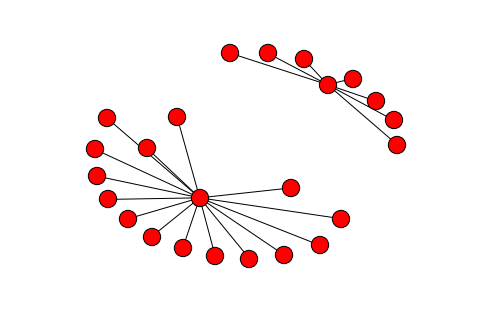


***********************
COMPONENT 0
***********************
Number of nodes  16
Number of edges  15
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
FAM230Closs : 1.0 15
OR11H1_POTEH_KCNMB3P1_CCT8L2_TPTEP1_XKR3_HSFY1P1_GAB4_CECR7_IL17RA_CECR6_CECR5_CECR1_CECR3_CECR9_RN7SL843Ploss : 0.07 1
SGSM1_TMEM211_KIAA1671_CRYBB3_CRYBB2loss : 0.07 1
---
Writing nodes to:  output/OV_broad-seg-jl--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  8
Number of edges  7
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
RN7SL605Ploss : 1.0 7
OR1D5_OR1D2_OR1G1_OR1A2_OR1A1_OR1D4_OR3A2_OR3A1_OR3A4P_OR1E1_OR3A3_OR1E2_SPATA22_ASPA_TRPV3_TRPV1_SHPK_CTNS_TAX1BP3_EMC6_P2RX5_ITGAE_GSG2_C17orf85_CAMKK1_P2RX1_ATP2A3_ZZEF1_RNA5SP434loss : 0.14 1
SMG6loss : 0.14 1
---
Writing nodes to:  output/OV_broad-seg-jl--cpairs-min_cohort_filtered_network_comp1.txt


In [14]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [15]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  22
Pair info of triplets initialized
0  triplets calculated in  0.0232977867126
Including sorting time  0.0239977836609


# ----------------------------------------------------------------------
# OV BROAD snv only loss RUNS
# ----------------------------------------------------------------------

# Set parameters

In [1]:
mutationmatrix = '/Users/jlu96/maf/new/OV_broad/OV_broad-som.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/OV_broad/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/OV_broad-som-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 50
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 4
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

4494 genes x 140 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


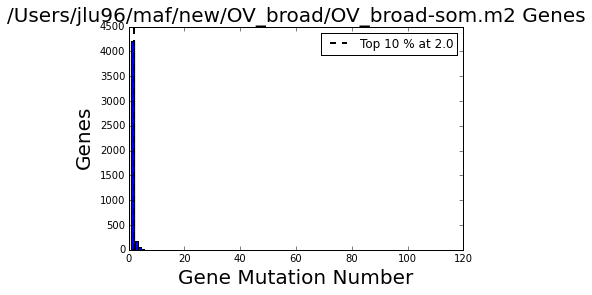

Zoomed into bottom 95 percent region


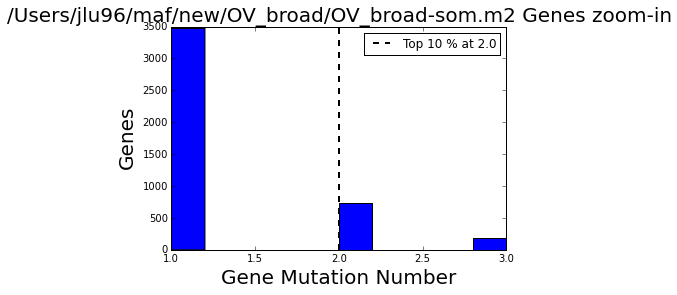


PATIENT MUTATION DISTRIBUTION


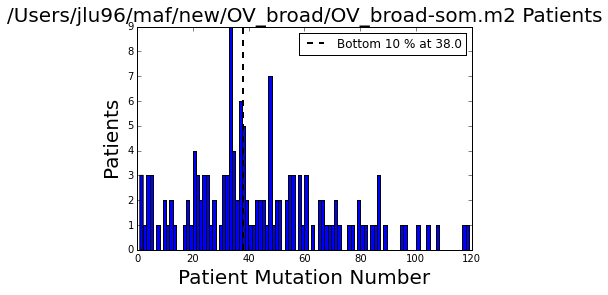

Zoomed into bottom 95 percent region


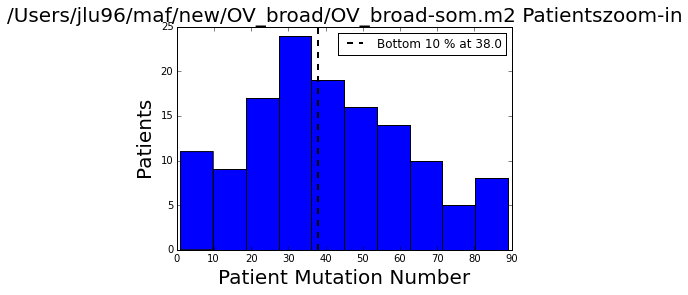

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


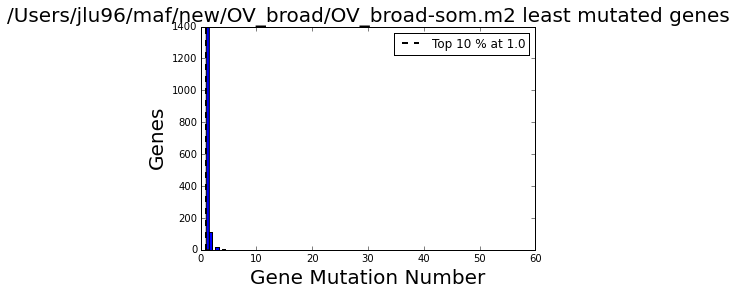


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


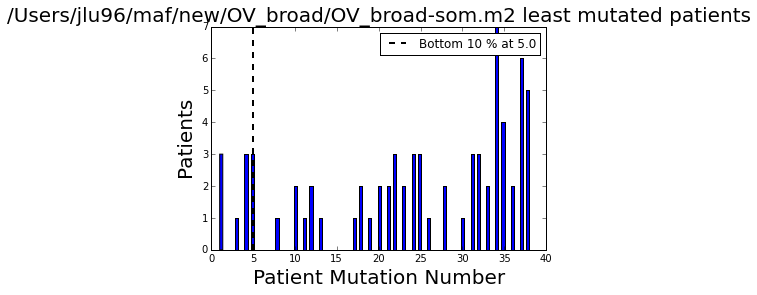

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  50  % of patients
Least mutated patients: 1532 genes x 72 patients
The test gene threshold is  4 % of the least mutated patients
Test genes are mutated at least  2  in th least mutated patients
Number of test genes:  134
Gene  FAM190B  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Gene  C10orf137  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Gene  CTSL1  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Gene  ZFP112  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Gene  FAM113B  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Number of pairs to test:  8513
Number of pairs is  8513  retrieved in time :  8.87039709091


0

In [2]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  3.54311513901
Testing among least mutated patients...
Finished in  7.41169786453
All pairs tested in least mutated patients written to  output/OV_broad-som-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


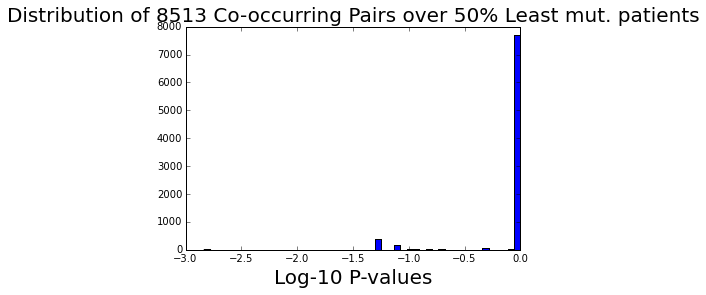

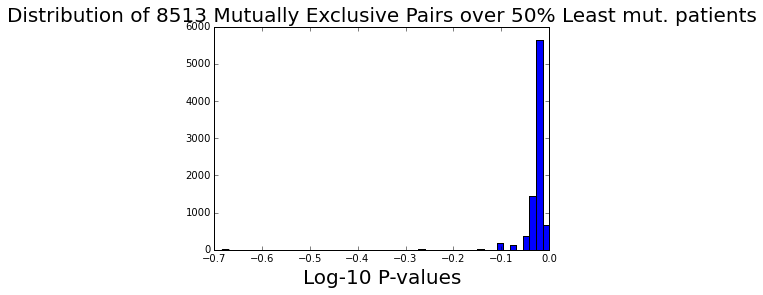

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [20]:
cpairPercentile = 0.05
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 0.05

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  0.05 percent of cooccurring pairs:  0.00324448293287
Top  0.05 percent of mutually exclusive pairs :  0.537415316383
Now number of mutex pairs to test  38
Now number of coocurr pairs to test  6
Number of genes  46


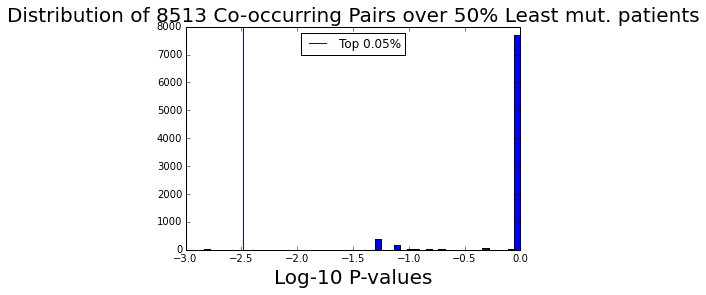

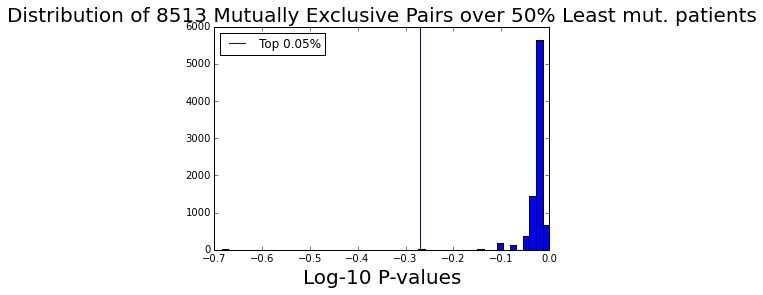

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [22]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/OV_broad-som--pairs-min_cohort_filtered.txt


0

### Plot results

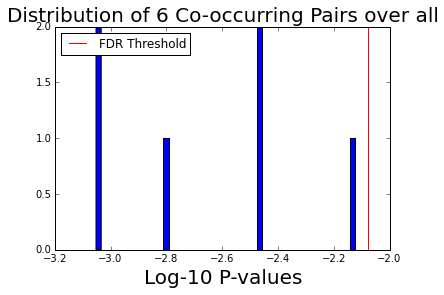

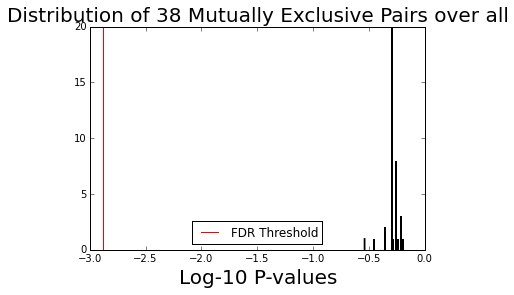

Number significant mutex 0
Number significant coocurr 6


In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One co-occurring pair with p=", cpvalues[0]

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One mutually exclusive pair with p=", mpvalues[0]


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [24]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/OV_broad-som--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

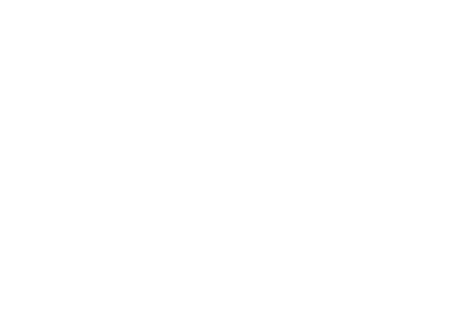

In [28]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [26]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

6  Co-occurring pairs
updated with segment info  output/OV_broad-som--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
PKD1L2 has 2
CDK12 has 2
PPARGC1A has 2
CASP1 has 1
FAM47A has 1
ASTN2 has 1
NLRP11 has 1
HECW1 has 1
CNTNAP5 has 1

**********SINGLE CYTOBANDS**********
['17q21.2'] has 2
['4p15.2'] has 2
['16q23.2'] has 2
['2q14.3'] has 1
['9q32'] has 1
['19q13.42'] has 1
['7p14.1', '7p13'] has 1
['Xp21.1'] has 1
['11q22.3'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['2q14.3']", "['9q32']"]) has 1
frozenset(["['Xp21.1']", "['7p14.1', '7p13']"]) has 1
frozenset(["['4p15.2']", "['16q23.2']"]) has 1
frozenset(["['17q21.2']", "['16q23.2']"]) has 1
frozenset(["['11q22.3']", "['19q13.42']"]) has 1
frozenset(["['4p15.2']", "['17q21.2']"]) has 1


0

# Draw co-occurrence network

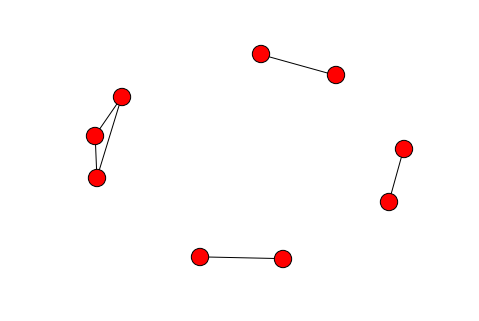


***********************
COMPONENT 0
***********************
Number of nodes  3
Number of edges  3
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
CDK12 : 1.0 2
PPARGC1A : 1.0 2
PKD1L2 : 1.0 2
---
Writing nodes to:  output/OV_broad-som--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
NLRP11 : 1.0 1
CASP1 : 1.0 1
---
Writing nodes to:  output/OV_broad-som--cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 2
Gene: Degree Centrality   Degree
FAM47A : 1.0 1
HECW1 : 1.0 1
---
Writing nodes to:  output/OV_broad-som--cpairs-min_cohort_filtered_network_comp2.txt

***********************
COMPONENT 3
***********************
Number of nodes  2


In [29]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [30]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  6
Pair info of triplets initialized
1  triplets calculated in  0.0144670009613
Including sorting time  0.0150721073151
1  of type  CooccurringCooccurringCooccurring
Triplets written to  output/OV_broad-som--triplets-CooccurringCooccurringCooccurring.txt
updated with COSMIC info  output/OV_broad-som--triplets-CooccurringCooccurringCooccurring.txt
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
CDK12 has 1
PPARGC1A has 1
PKD1L2 has 1

**********SINGLE CYTOBANDS**********
['4p15.2'] has 1
['17q21.2'] has 1
['16q23.2'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['4p15.2']", "['17q21.2']", "['16q23.2']"]) has 1


# ----------------------------------------------------------------------
# OV BROAD SNV and SEGMENT only loss RUNS
# ----------------------------------------------------------------------

# Set parameters

In [3]:
mutationmatrix = '/Users/jlu96/maf/new/OV_broad/OV_broad-som-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/OV_broad/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/OV_broad-som-seg-jl-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 9
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 30
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

9674 genes x 140 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


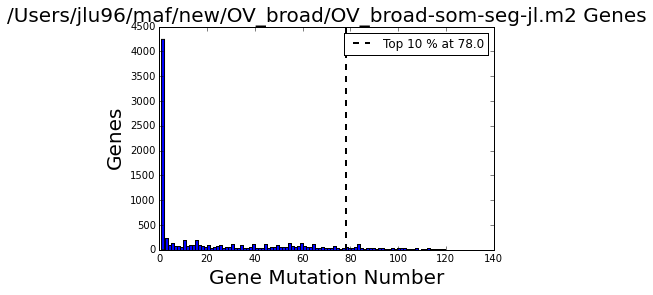

Zoomed into bottom 95 percent region


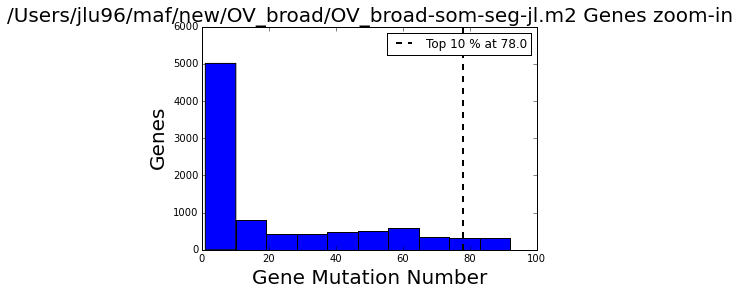


PATIENT MUTATION DISTRIBUTION


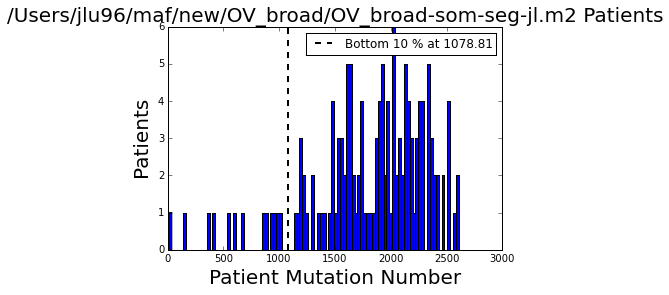

Zoomed into bottom 95 percent region


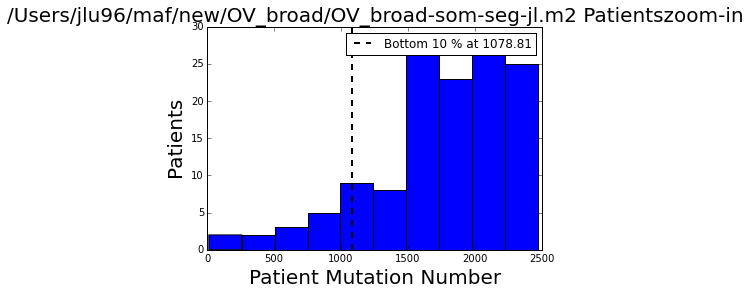

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


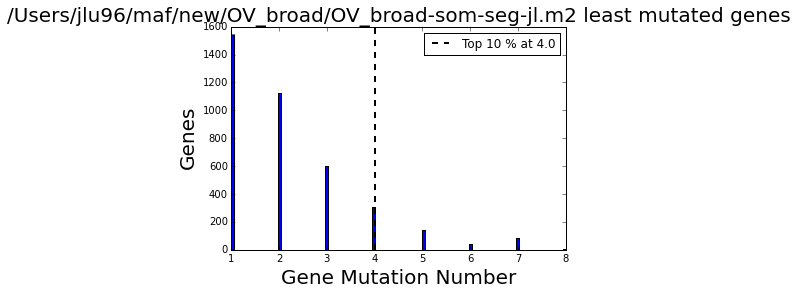


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


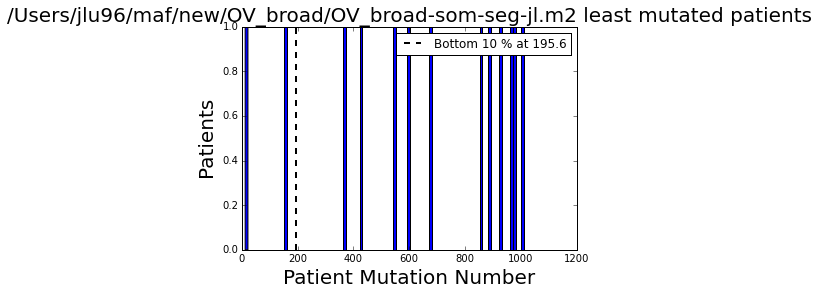

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  9  % of patients
Least mutated patients: 3847 genes x 13 patients
The test gene threshold is  30 % of the least mutated patients
Test genes are mutated at least  3  in th least mutated patients
Number of test genes:  1182
Number of pairs to test:  646126
Number of pairs is  646126  retrieved in time :  19.3980419636


0

In [4]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [6]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  327.289721966
Testing among least mutated patients...
Finished in  1209.19584489
All pairs tested in least mutated patients written to  output/OV_broad-som-seg-jl-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


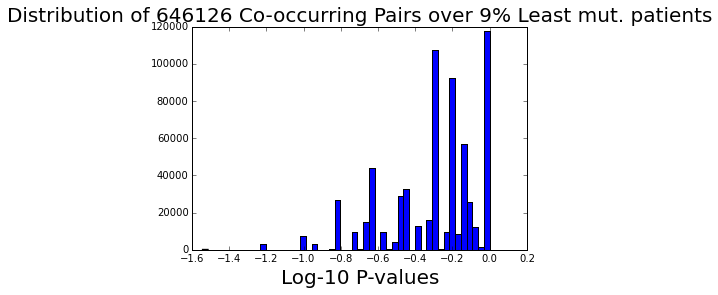

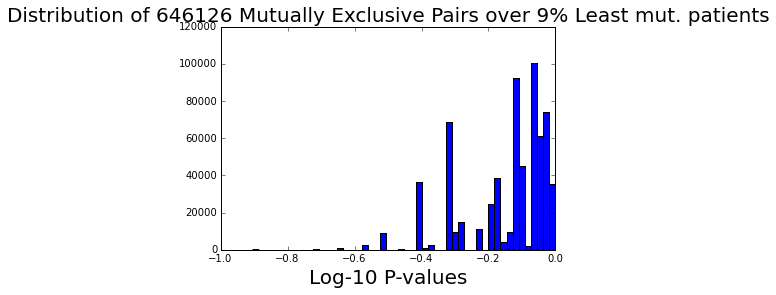

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [10]:
cpairPercentile = 0.5
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 0.05

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  0.5 percent of cooccurring pairs:  0.0598183437476
Top  0.05 percent of mutually exclusive pairs :  0.194488680277
Now number of mutex pairs to test  724
Now number of coocurr pairs to test  3414
Number of genes  589


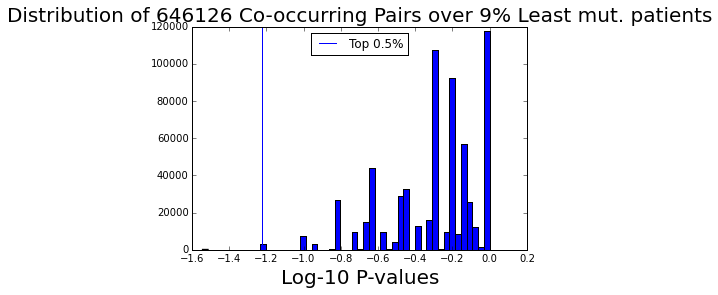

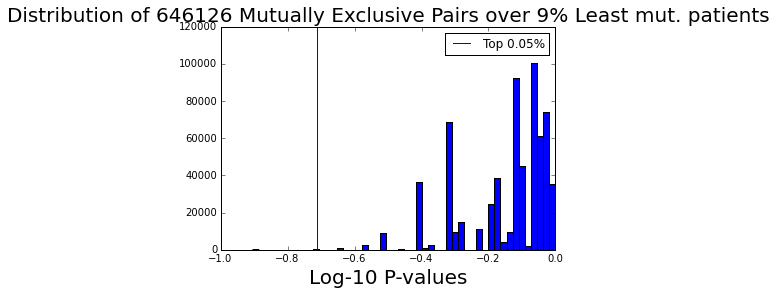

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [12]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/OV_broad-som-seg-jl--pairs-min_cohort_filtered.txt


0

### Plot results

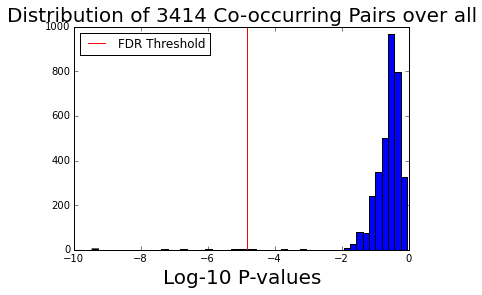

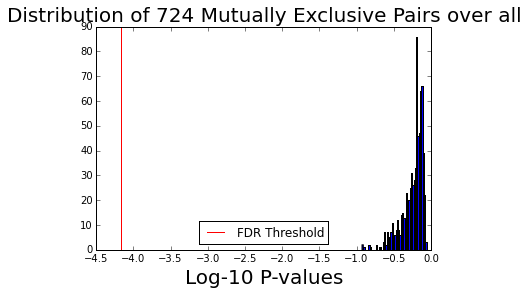

Number significant mutex 0
Number significant coocurr 29


In [13]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One co-occurring pair with p=", cpvalues[0]

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One mutually exclusive pair with p=", mpvalues[0]


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [14]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/OV_broad-som-seg-jl--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som-seg-jl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

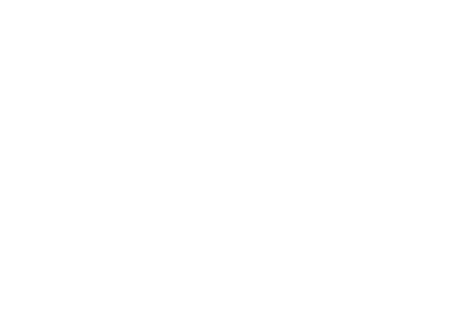

In [15]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [16]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

29  Co-occurring pairs
updated with segment info  output/OV_broad-som-seg-jl--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som-seg-jl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 16
KCNQ1DNloss has 9
RN7SL605Ploss has 4
CDKN1C_SLC22A18loss has	1
CECR2loss has 1
MIR648loss has 1
CABIN1loss has 1
SPECC1L_ADORA2Aloss has	1
SUSD2_GGT5_POM1loss has	1
ASCL2_C11orf21_loss has	1
LRP5L_CRYBB2P1_loss has	1
BET1L_SCGB1C1_Oloss has	1
OR1D5_OR1D2_OR1loss has	1
PPM1F_TOP3B_VPRloss has	1
SLC25A18_ATP6V1loss has	1
PIWIL3loss has 1
IGF2_MIR483_INSloss has	1
RN7SL33P_PAFAH1loss has	1
OR11H1_POTEH_KCloss has	1
MICAL3loss has 1
RRM1loss has 1
OSBPL5loss has 1
RNA5SP493loss has 1
MAPK1loss has 1
PEX26_TUBA8_USPloss has	1
KCNQ1OT1loss has 1
KCNQ1loss has 1
RAP1GAP2loss has 1
SGSM1_TMEM211_Kloss has	1
RTN4RL1_DPH1_OVloss has	1
MRGPRG_MRGPRE_Zloss has	1
IGLL1_GUSBP11_Rloss has	1

**********SINGLE CYTOBANDS**

0

# Draw co-occurrence network

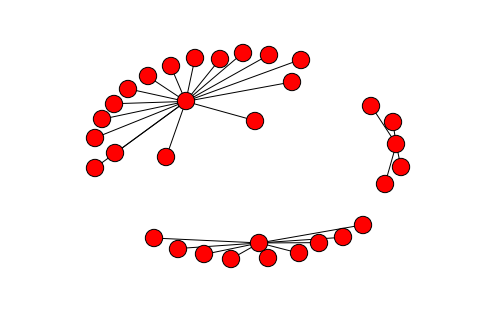


***********************
COMPONENT 0
***********************
Number of nodes  10
Number of edges  9
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
KCNQ1DNloss : 1.0 9
CDKN1C_SLC22A18AS_SLC22A18_PHLDA2_NAP1L4_SNORA54_CARSloss : 0.11 1
KCNQ1OT1loss : 0.11 1
---
Writing nodes to:  output/OV_broad-som-seg-jl--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  17
Number of edges  16
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
FAM230Closs : 1.0 16
OR11H1_POTEH_KCNMB3P1_CCT8L2_TPTEP1_XKR3_HSFY1P1_GAB4_CECR7_IL17RA_CECR6_CECR5_CECR1_CECR3_CECR9_RN7SL843Ploss : 0.06 1
MIR648loss : 0.06 1
---
Writing nodes to:  output/OV_broad-som-seg-jl--cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  5
Number of edges  4
---
Top 3 nodes by degree centraliy in component 2
Gene: Degree Centra

In [18]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [19]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  29
Pair info of triplets initialized
0  triplets calculated in  0.00366902351379
Including sorting time  0.00374603271484


# ----------------------------------------------------------------------
# OV BROAD SNV and SEGMENT only gain RUNS
# ----------------------------------------------------------------------

# Set parameters

In [1]:
mutationmatrix = '/Users/jlu96/maf/new/OV_broad/OV_broad-som-seg-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/OV_broad/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/OV_broad-som-seg-gl-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 9
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 50
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

14854 genes x 140 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


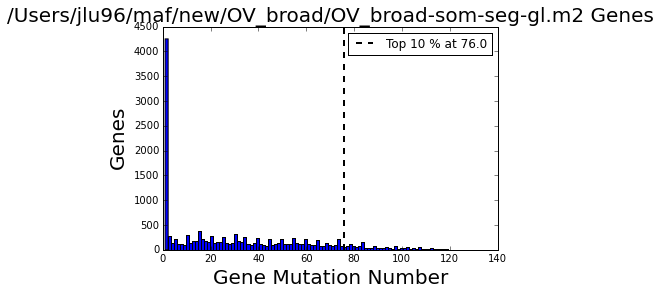

Zoomed into bottom 95 percent region


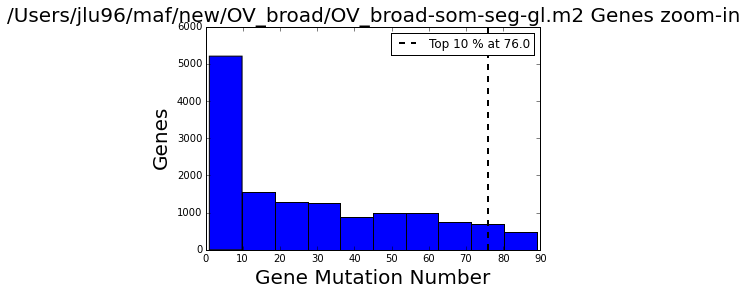


PATIENT MUTATION DISTRIBUTION


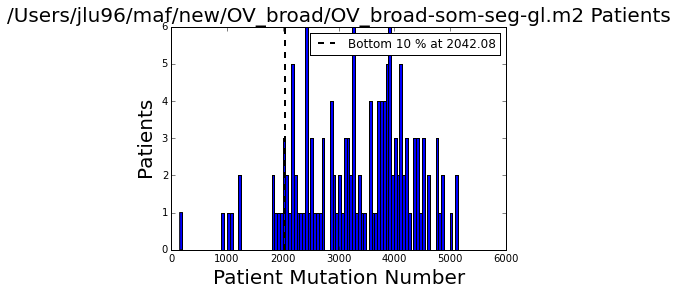

Zoomed into bottom 95 percent region


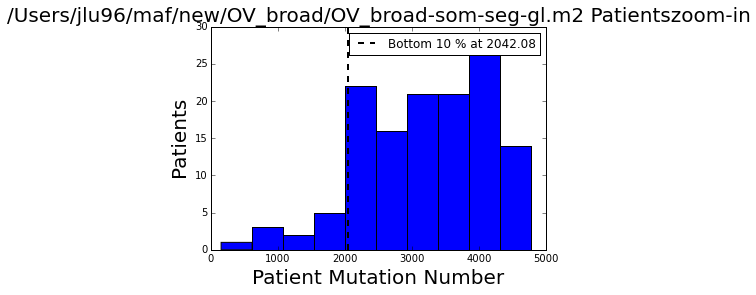

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


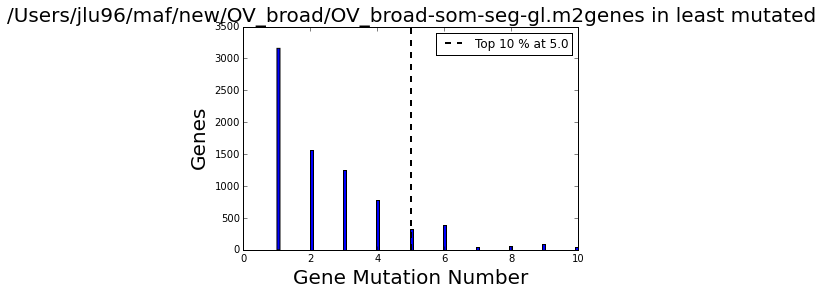


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


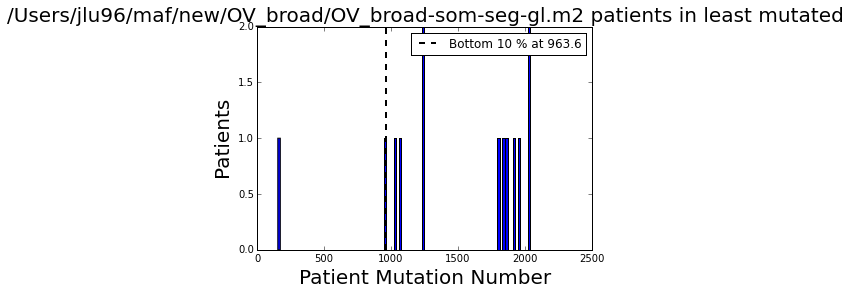

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  9  % of patients
Least mutated patients: 7712 genes x 13 patients
The test gene threshold is  50 % of the least mutated patients
Test genes are mutated at least  6  in th least mutated patients
Number of test genes:  610
Number of pairs to test:  152831
Number of pairs is  152831  retrieved in time :  59.2352659702


0

In [2]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + "genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  90.2008600235
Testing among least mutated patients...
Finished in  156.275716066
All pairs tested in least mutated patients written to  output/OV_broad-som-seg-gl-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


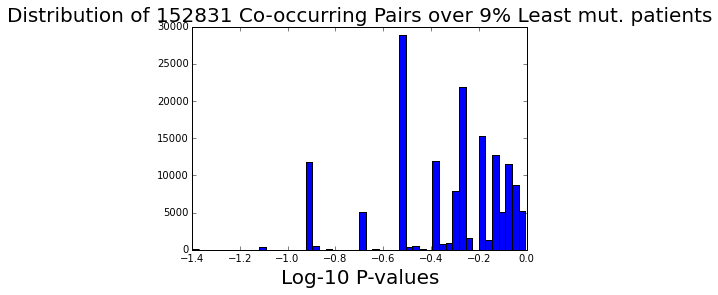

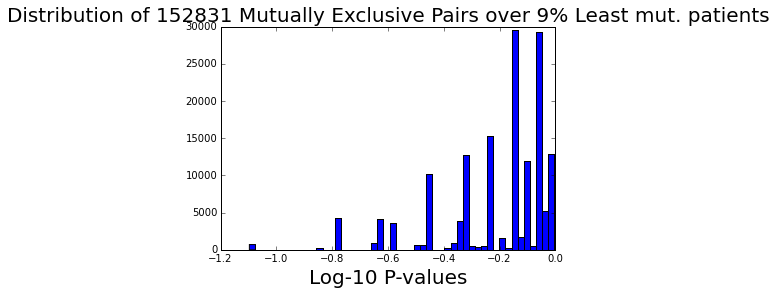

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [15]:
cpairPercentile = 0.05
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 0.0001

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  0.05 percent of cooccurring pairs:  0.0782428289521
Top  0.0001 percent of mutually exclusive pairs :  0.0799932895494
Now number of mutex pairs to test  704
Now number of coocurr pairs to test  466
Number of genes  137


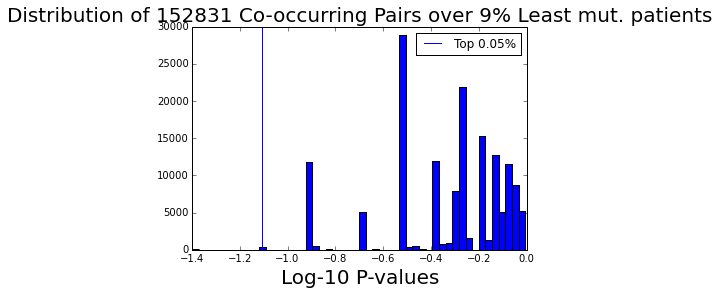

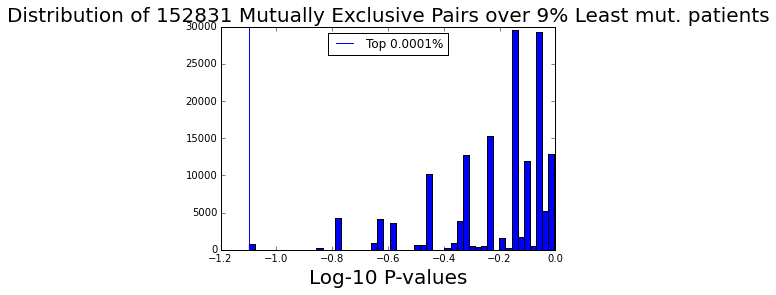

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [17]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/OV_broad-som-seg-gl--pairs-min_cohort_filtered.txt


0

### Plot results

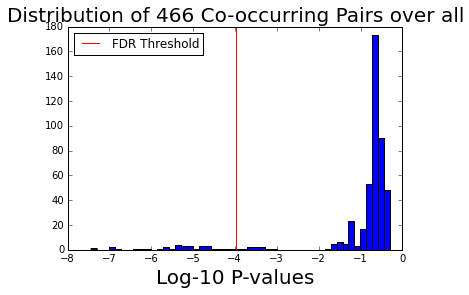

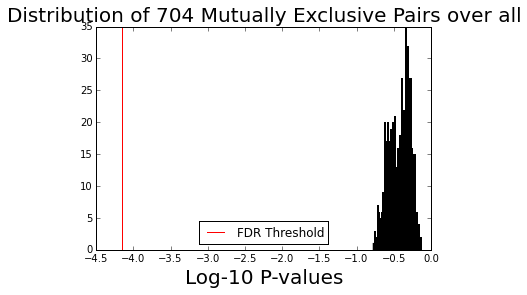

Number significant mutex 0
Number significant coocurr 32


In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One co-occurring pair with p=", cpvalues[0]

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One mutually exclusive pair with p=", mpvalues[0]


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [19]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/OV_broad-som-seg-gl--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som-seg-gl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

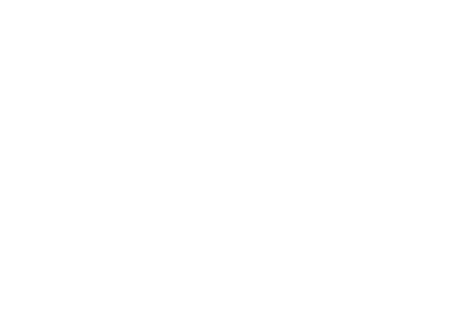

In [20]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [21]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

32  Co-occurring pairs
updated with segment info  output/OV_broad-som-seg-gl--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/OV_broad-som-seg-gl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
RN7SL605Ploss has 17
SNORA44gain has 15
CYB5D2_ANKFY1loss has 1
WSCD1loss has 1
SEMA4A_SLC25A44gain has	1
MYO1C_INPP5K_PIloss has	1
CRKloss has 1
VPS45_PLEKHO1_Rgain has	1
UBE2G1_RN7SL774loss has	1
MSTO1_YY1AP1_DAgain has	1
KCNN3gain has 1
CELF3_RIIAD1_MRgain has	1
ASGR1_DLG4_ACADloss has	1
YWHAEloss has 1
OR1D5_OR1D2_OR1loss has	1
RN7SL624Ploss has 1
GON4Lgain has 1
FCRL5_FCRL4_FCRgain has	1
SELENBP1_PSMB4_gain has	1
SNX27gain has 1
SLC43A2_RN7SL10loss has	1
AIPL1_FAM64A_KIloss has	1
PMVK_PBXIP1_PYGgain has	1
RN7SL33P_PAFAH1loss has	1
SYT11_RIT1_KIAAgain has	1
DOC2B_RPH3AL_C1loss has	1
ASH1L_MIR555gain has 1
SF3B4_MTMR11_OTgain has	1
SMG6loss has 1
S100A16_S100A14gain has	1
RAP1GAP2loss has 1
SRR_TSR1_SNORD9loss has	1
RTN4R

0

# Draw co-occurrence network

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


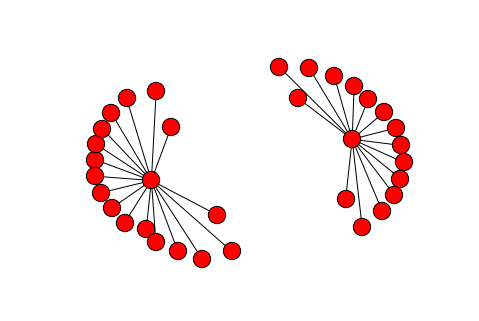


***********************
COMPONENT 0
***********************
Number of nodes  18
Number of edges  17
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
RN7SL605Ploss : 1.0 17
CYB5D2_ANKFY1loss : 0.06 1
WSCD1loss : 0.06 1
---
Writing nodes to:  output/OV_broad-som-seg-gl--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  16
Number of edges  15
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
SNORA44gain : 1.0 15
SNX27gain : 0.07 1
SEMA4A_SLC25A44_PMF1_BGLAP_PAQR6_SMG5_TMEM79_VHLL_CCT3_TSACC_RHBG_C1orf61_MEF2D_IQGAP3_TTC24_APOA1BP_GPATCH4_HAPLN2_BCAN_NES_CRABP2_ISG20L2_RRNAD1_MRPL24_HDGF_PRCC_SH2D2A_NTRK1_INSRR_PEAR1_LRRC71_ARHGEF11_MIR765_RN7SL612P_ETV3L_ETV3gain : 0.07 1
---
Writing nodes to:  output/OV_broad-som-seg-gl--cpairs-min_cohort_filtered_network_comp1.txt


In [22]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [23]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  32
Pair info of triplets initialized
0  triplets calculated in  0.00085186958313
Including sorting time  0.000962972640991
